In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

In [2]:
%cd /content
!unzip /mydrive/HAKATON.zip

Streaming output truncated to the last 5000 lines.
  inflating: HAKATON/Dataset/DogCategories/ТОЛЬКО СОБАКА -разноцветный - длинный хвост/736.jpg  
  inflating: HAKATON/Dataset/DogCategories/ТОЛЬКО СОБАКА -разноцветный - длинный хвост/744.jpg  
  inflating: HAKATON/Dataset/DogCategories/ТОЛЬКО СОБАКА -разноцветный - длинный хвост/764.jpg  
  inflating: HAKATON/Dataset/DogCategories/ТОЛЬКО СОБАКА -разноцветный - длинный хвост/769.jpg  
  inflating: HAKATON/Dataset/DogCategories/ТОЛЬКО СОБАКА -разноцветный - длинный хвост/776.jpg  
  inflating: HAKATON/Dataset/DogCategories/ТОЛЬКО СОБАКА -разноцветный - длинный хвост/777.jpg  
  inflating: HAKATON/Dataset/DogCategories/ТОЛЬКО СОБАКА -разноцветный - длинный хвост/797.jpg  
  inflating: HAKATON/Dataset/DogCategories/ТОЛЬКО СОБАКА -разноцветный - длинный хвост/800.jpg  
  inflating: HAKATON/Dataset/DogCategories/ТОЛЬКО СОБАКА -разноцветный - длинный хвост/805.jpg  
  inflating: HAKATON/Dataset/DogCategories/ТОЛЬКО СОБАКА -разноцвет

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import cv2
import shutil
import random
from multiprocessing.pool import ThreadPool

clear_output()

In [4]:
config = {
        "model_name_local":"DogCategory_v1.1",
        "note":"Модель предназнаена для определения категории к которой принадлежит собака",
        "batch_size":16,
        "input_image_height":60,
        "input_image_weight":70,
        "input_image_color_channels":3,
        "dropout_value": None,
        "epochs":100,
        "ft_epochs":100,
        "optimizer_name":"adam",
        "loss":"categorical_crossentropy",
        "learning_rate": 0.01,
        "learning_rate_ft": 0.001,
        "acc_metrics":"accuracy",
        "validation_split":0.2,
        "number_of_train_images":513,
        "number_of_test_images":126,
        "number_of_classes":6,
        "augmentation":True,
        "augmentation_description":"Горизонтальный переворот"
        }

In [5]:
PATH = "./HAKATON/yolov5/data/DogCategories_cropped"

In [6]:
def data_generator(PATH,batch_size,IMG_HEIGHT,IMG_WIDTH,validation_split,class_mode='categorical'):
    
    #Выделяем тренировочный и тестовый датасеты
    train_dir = os.path.join(PATH)
    
    train_multlong_dir = os.path.join(train_dir, 'DOG ONLY - multicolored - long tail')  
    train_multshort_dir = os.path.join(train_dir, 'DOG ONLY - multicolored - short tail') 
    train_darklong_dir = os.path.join(train_dir, 'DOG ONLY DARK LONG')  
    train_darkshort_dir = os.path.join(train_dir, 'DOG ONLY DARK SHORT')  
    train_lightlong_dir = os.path.join(train_dir, 'DOG ONLY LIGHT LONG')  
    train_lightshort_dir = os.path.join(train_dir, 'DOG ONLY LIGHT SHORT')
    #Подсчитываем количество собак в каждом из классов
    num_multlong_tr = len(os.listdir(train_multlong_dir))
    num_multshort_tr = len(os.listdir(train_multshort_dir))
    num_darklong_tr = len(os.listdir(train_darklong_dir))
    num_darkshort_tr = len(os.listdir(train_darkshort_dir))
    num_lightlong_tr = len(os.listdir(train_lightlong_dir))
    num_lightshort_tr = len(os.listdir(train_lightshort_dir))

    total_train = num_multlong_tr + num_multshort_tr + num_darklong_tr + num_darkshort_tr + num_lightlong_tr + num_lightshort_tr
    step_per_epoch_test = (total_train * validation_split) // batch_size
    step_per_epoch_train = (total_train - (total_train * validation_split)) // batch_size
    print("|Total dogs per class|")
    print('|Multicolored - long tail:', num_multlong_tr)
    print('|Multicolored - short tail:', num_multshort_tr)
    print('|DARK LONG:', num_darklong_tr)
    print('|DARK SHORT:', num_darkshort_tr)
    print('|LIGHT LONG:', num_lightlong_tr)
    print('|LIGHT SHORT:', num_lightshort_tr)
    print(" ")
    print("|Total photosets: {}|".format(total_train))
    print(" ")
    print("|Steps per epochs train: {}|".format(step_per_epoch_train))
    print("|Steps per epochs test: {}|".format(step_per_epoch_test))
    print("--------------------------")
    print(" ")
    print("Class mode:", class_mode)
    train_image_generator = ImageDataGenerator(rescale=1./255,
                                               validation_split=validation_split) # Генератор для тренировочных данных
    
    print("Train DataGenerator:")
    train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                            color_mode="rgb",
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode=class_mode,
                                                              subset='training')
    print(" ")
    print("Test DataGenerator:")
    val_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=train_dir,
                                                             color_mode="rgb",
                                                             shuffle=False,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode=class_mode,
                                                            subset='validation')
    return train_data_gen, val_data_gen, step_per_epoch_test, step_per_epoch_train

In [7]:
train_data_gen, val_data_gen, step_per_epoch_test, step_per_epoch_train  = data_generator(PATH,config['batch_size'],config['input_image_height'],config['input_image_weight'],config['validation_split'])

|Total dogs per class|
|Multicolored - long tail: 70
|Multicolored - short tail: 78
|DARK LONG: 110
|DARK SHORT: 126
|LIGHT LONG: 127
|LIGHT SHORT: 128
 
|Total photosets: 639|
 
|Steps per epochs train: 31.0|
|Steps per epochs test: 7.0|
--------------------------
 
Class mode: categorical
Train DataGenerator:
Found 513 images belonging to 6 classes.
 
Test DataGenerator:
Found 126 images belonging to 6 classes.


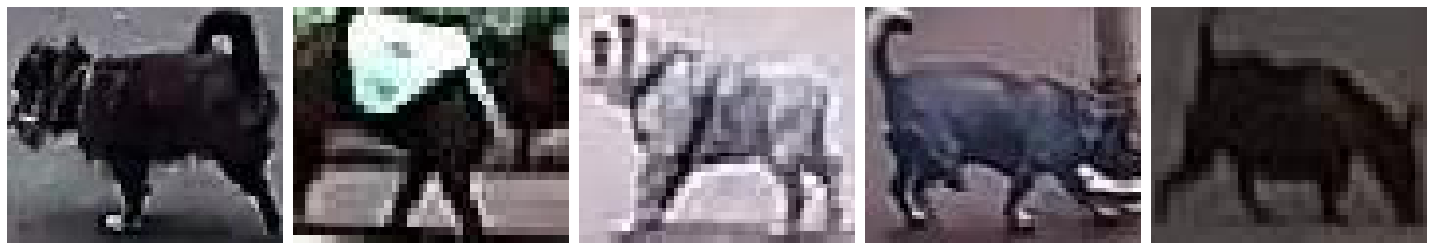

In [8]:
sample_training_images, _ = next(train_data_gen)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
plotImages(sample_training_images[:5])

In [2]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Lambda, concatenate, Activation, Dropout
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD

import keras
from tensorflow.keras import layers

In [10]:
def model_making(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(6))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=config["learning_rate"]),
                metrics=['accuracy'])
    return model

model = model_making((60, 70, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 58, 68, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 58, 68, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 34, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 27, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 14, 64)        1

In [11]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20) # Early stopping (stops training when validation doesn't improve for {patience} epochs)
model_filepath = './models/some_layers'
save_best = keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_loss', save_best_only=True, mode='min') # Saves the best version of the model to disk (as measured on the validation data set)
history = model.fit(
        train_data_gen,
        steps_per_epoch=step_per_epoch_train,
        epochs=config["epochs"],
        validation_data=val_data_gen,
        validation_steps=step_per_epoch_test,
        #shuffle = True,
        callbacks=[es, save_best])

Epoch 1/100
31/31 [==============================] - 31s 26ms/step - loss: 1.8219 - accuracy: 0.2328 - val_loss: 1.6065 - val_accuracy: 0.3036
INFO:tensorflow:Assets written to: ./models/some_layers/assets
Epoch 2/100
31/31 [==============================] - 1s 18ms/step - loss: 1.5876 - accuracy: 0.3098 - val_loss: 1.5519 - val_accuracy: 0.3661
INFO:tensorflow:Assets written to: ./models/some_layers/assets
Epoch 3/100
31/31 [==============================] - 1s 16ms/step - loss: 1.6575 - accuracy: 0.2911 - val_loss: 1.6572 - val_accuracy: 0.2857
Epoch 4/100
31/31 [==============================] - 1s 16ms/step - loss: 1.6258 - accuracy: 0.3056 - val_loss: 1.6851 - val_accuracy: 0.2411
Epoch 5/100
31/31 [==============================] - 1s 18ms/step - loss: 1.5684 - accuracy: 0.2994 - val_loss: 1.5470 - val_accuracy: 0.2857
INFO:tensorflow:Assets written to: ./models/some_layers/assets
Epoch 6/100
31/31 [==============================] - 1s 18ms/step - loss: 1.5147 - accuracy: 0.3555 

In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=config["learning_rate_ft"])
model.compile(optimizer=optimizer, loss=config['loss'], metrics=["accuracy"])

In [13]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40) # Early stopping (stops training when validation doesn't improve for {patience} epochs)
model_filepath = './models/some_layers_ft'
save_best = keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_loss', save_best_only=True, mode='min') # Saves the best version of the model to disk (as measured on the validation data set)
history_unfreez = model.fit(
        train_data_gen,
        steps_per_epoch=step_per_epoch_train,
        epochs=config["ft_epochs"],
        validation_data=val_data_gen,
        validation_steps=step_per_epoch_test,
        #shuffle = True,
        callbacks=[es, save_best])

Epoch 1/100
31/31 [==============================] - 1s 24ms/step - loss: 0.3320 - accuracy: 0.8815 - val_loss: 3.0462 - val_accuracy: 0.4018
INFO:tensorflow:Assets written to: ./models/some_layers_ft/assets
Epoch 2/100
31/31 [==============================] - 1s 19ms/step - loss: 0.2760 - accuracy: 0.9085 - val_loss: 3.1368 - val_accuracy: 0.3929
Epoch 3/100
31/31 [==============================] - 1s 16ms/step - loss: 0.2580 - accuracy: 0.9148 - val_loss: 3.3380 - val_accuracy: 0.3929
Epoch 4/100
31/31 [==============================] - 0s 16ms/step - loss: 0.2307 - accuracy: 0.9210 - val_loss: 3.3426 - val_accuracy: 0.3750
Epoch 5/100
31/31 [==============================] - 1s 16ms/step - loss: 0.2203 - accuracy: 0.9252 - val_loss: 3.4358 - val_accuracy: 0.4018
Epoch 6/100
31/31 [==============================] - 0s 16ms/step - loss: 0.2061 - accuracy: 0.9480 - val_loss: 3.6169 - val_accuracy: 0.3929
Epoch 7/100
31/31 [==============================] - 1s 16ms/step - loss: 0.1916 -

# Pretrained

In [14]:
from tensorflow.keras.applications import MobileNetV2

MN = MobileNetV2(weights='imagenet', 
                  include_top=False,      
                  input_shape=(60, 70, 3))
MN.trainable = False               
#MN.summary() 

9420800/9406464 [==============================] - 0s 0us/step


In [17]:
model2 = Sequential()
model2.add(MN)

model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
#model2.add(Dropout(0.5))
model2.add(Dense(6, activation='softmax'))

model2.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-5), 
              metrics=['accuracy'])

model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 2, 3, 1280)        2257984   
_________________________________________________________________
flatten_2 (Flatten)          (None, 7680)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               1966336   
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 1542      
Total params: 4,225,862
Trainable params: 1,967,878
Non-trainable params: 2,257,984
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [18]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=45) # Early stopping (stops training when validation doesn't improve for {patience} epochs)
model_filepath = './models/mobilenet'
save_best = keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_loss', save_best_only=True, mode='min') # Saves the best version of the model to disk (as measured on the validation data set)
history = model2.fit(
        train_data_gen,
        steps_per_epoch=step_per_epoch_train,
        epochs=config["epochs"],
        validation_data=val_data_gen,
        validation_steps=step_per_epoch_test,
        #shuffle = True,
        callbacks=[es, save_best])

Epoch 1/100
31/31 [==============================] - 5s 53ms/step - loss: 2.3868 - accuracy: 0.1774 - val_loss: 1.9268 - val_accuracy: 0.3036


INFO:tensorflow:Assets written to: ./models/mobilenet/assets


INFO:tensorflow:Assets written to: ./models/mobilenet/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
31/31 [==============================] - 1s 23ms/step - loss: 1.8197 - accuracy: 0.3105 - val_loss: 1.8755 - val_accuracy: 0.3304


INFO:tensorflow:Assets written to: ./models/mobilenet/assets


INFO:tensorflow:Assets written to: ./models/mobilenet/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/100
31/31 [==============================] - 1s 24ms/step - loss: 1.4907 - accuracy: 0.4096 - val_loss: 1.8676 - val_accuracy: 0.3393


INFO:tensorflow:Assets written to: ./models/mobilenet/assets


INFO:tensorflow:Assets written to: ./models/mobilenet/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/100
31/31 [==============================] - 1s 24ms/step - loss: 1.2758 - accuracy: 0.5094 - val_loss: 1.8445 - val_accuracy: 0.3393


INFO:tensorflow:Assets written to: ./models/mobilenet/assets


INFO:tensorflow:Assets written to: ./models/mobilenet/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/100
31/31 [==============================] - 1s 23ms/step - loss: 1.1142 - accuracy: 0.5967 - val_loss: 1.8386 - val_accuracy: 0.3571


INFO:tensorflow:Assets written to: ./models/mobilenet/assets


INFO:tensorflow:Assets written to: ./models/mobilenet/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/100
31/31 [==============================] - 1s 23ms/step - loss: 0.9531 - accuracy: 0.6875 - val_loss: 1.8616 - val_accuracy: 0.3482
Epoch 7/100
31/31 [==============================] - 1s 23ms/step - loss: 0.8411 - accuracy: 0.7526 - val_loss: 1.8683 - val_accuracy: 0.3482
Epoch 8/100
31/31 [==============================] - 1s 23ms/step - loss: 0.7495 - accuracy: 0.7838 - val_loss: 1.8700 - val_accuracy: 0.3571
Epoch 9/100
31/31 [==============================] - 1s 23ms/step - loss: 0.6753 - accuracy: 0.8150 - val_loss: 1.8900 - val_accuracy: 0.3482
Epoch 10/100
31/31 [==============================] - 1s 22ms/step - loss: 0.5969 - accuracy: 0.8669 - val_loss: 1.8923 - val_accuracy: 0.3393
Epoch 11/100
31/31 [==============================] - 1s 23ms/step - loss: 0.5384 - accuracy: 0.8960 - val_loss: 1.9157 - val_accuracy: 0.3482
Epoch 12/100
31/31 [==============================] - 1s 23ms/step - loss: 0.4910 - accuracy: 0.9168 - val_loss: 1.9162 - val_accuracy: 0.3571
Epo

In [19]:
from tensorflow.keras.applications import ResNet50V2

RN = ResNet50V2(weights='imagenet', 
                  include_top=False,      
                  input_shape=(60, 70, 3))
RN.trainable = False               
#MN.summary() 

94683136/94668760 [==============================] - 3s 0us/step


In [20]:
model3 = Sequential()
model3.add(RN)

model3.add(Flatten())
model3.add(Dense(256, activation='relu'))
#model3.add(Dropout(0.5))
model3.add(Dense(6, activation='softmax'))

model3.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-5), 
              metrics=['accuracy'])

model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2, 3, 2048)        23564800  
_________________________________________________________________
flatten_3 (Flatten)          (None, 12288)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               3145984   
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 1542      
Total params: 26,712,326
Trainable params: 3,147,526
Non-trainable params: 23,564,800
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [21]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=45) # Early stopping (stops training when validation doesn't improve for {patience} epochs)
model_filepath = './models/resnet'
save_best = keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_loss', save_best_only=True, mode='min') # Saves the best version of the model to disk (as measured on the validation data set)
history = model3.fit(
        train_data_gen,
        steps_per_epoch=step_per_epoch_train,
        epochs=config["epochs"],
        validation_data=val_data_gen,
        validation_steps=step_per_epoch_test,
        #shuffle = True,
        callbacks=[es, save_best])

Epoch 1/100
31/31 [==============================] - 7s 87ms/step - loss: 3.1468 - accuracy: 0.1975 - val_loss: 2.2758 - val_accuracy: 0.2679
INFO:tensorflow:Assets written to: ./models/resnet/assets


INFO:tensorflow:Assets written to: ./models/resnet/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
31/31 [==============================] - 1s 44ms/step - loss: 1.9141 - accuracy: 0.3597 - val_loss: 1.9719 - val_accuracy: 0.3304
INFO:tensorflow:Assets written to: ./models/resnet/assets


INFO:tensorflow:Assets written to: ./models/resnet/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/100
31/31 [==============================] - 1s 43ms/step - loss: 1.4432 - accuracy: 0.5031 - val_loss: 1.8688 - val_accuracy: 0.3571
INFO:tensorflow:Assets written to: ./models/resnet/assets


INFO:tensorflow:Assets written to: ./models/resnet/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/100
31/31 [==============================] - 1s 45ms/step - loss: 1.1355 - accuracy: 0.6008 - val_loss: 1.8450 - val_accuracy: 0.3571
INFO:tensorflow:Assets written to: ./models/resnet/assets


INFO:tensorflow:Assets written to: ./models/resnet/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/100
31/31 [==============================] - 1s 44ms/step - loss: 0.9628 - accuracy: 0.6715 - val_loss: 1.8334 - val_accuracy: 0.3750
INFO:tensorflow:Assets written to: ./models/resnet/assets


INFO:tensorflow:Assets written to: ./models/resnet/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/100
31/31 [==============================] - 1s 45ms/step - loss: 0.8004 - accuracy: 0.7339 - val_loss: 1.8147 - val_accuracy: 0.3571
INFO:tensorflow:Assets written to: ./models/resnet/assets


INFO:tensorflow:Assets written to: ./models/resnet/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/100
31/31 [==============================] - 1s 45ms/step - loss: 0.6821 - accuracy: 0.8046 - val_loss: 1.8264 - val_accuracy: 0.3750
Epoch 8/100
31/31 [==============================] - 1s 41ms/step - loss: 0.5937 - accuracy: 0.8462 - val_loss: 1.8343 - val_accuracy: 0.3750
Epoch 9/100
31/31 [==============================] - 1s 40ms/step - loss: 0.5214 - accuracy: 0.8877 - val_loss: 1.8011 - val_accuracy: 0.3839
INFO:tensorflow:Assets written to: ./models/resnet/assets


INFO:tensorflow:Assets written to: ./models/resnet/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/100
31/31 [==============================] - 1s 41ms/step - loss: 0.4598 - accuracy: 0.9127 - val_loss: 1.8003 - val_accuracy: 0.3839
INFO:tensorflow:Assets written to: ./models/resnet/assets


INFO:tensorflow:Assets written to: ./models/resnet/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 11/100
31/31 [==============================] - 1s 44ms/step - loss: 0.4042 - accuracy: 0.9293 - val_loss: 1.7868 - val_accuracy: 0.4018
INFO:tensorflow:Assets written to: ./models/resnet/assets


INFO:tensorflow:Assets written to: ./models/resnet/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 12/100
31/31 [==============================] - 1s 45ms/step - loss: 0.3544 - accuracy: 0.9459 - val_loss: 1.7870 - val_accuracy: 0.3929
Epoch 13/100
31/31 [==============================] - 1s 40ms/step - loss: 0.3250 - accuracy: 0.9584 - val_loss: 1.7908 - val_accuracy: 0.4018
Epoch 14/100
31/31 [==============================] - 1s 41ms/step - loss: 0.2998 - accuracy: 0.9647 - val_loss: 1.7875 - val_accuracy: 0.4018
Epoch 15/100
31/31 [==============================] - 1s 41ms/step - loss: 0.2732 - accuracy: 0.9730 - val_loss: 1.8226 - val_accuracy: 0.4107
Epoch 16/100
31/31 [==============================] - 1s 41ms/step - loss: 0.2499 - accuracy: 0.9792 - val_loss: 1.8128 - val_accuracy: 0.4107
Epoch 17/100
31/31 [==============================] - 1s 42ms/step - loss: 0.2302 - accuracy: 0.9813 - val_loss: 1.7988 - val_accuracy: 0.4018
Epoch 18/100
31/31 [==============================] - 1s 41ms/step - loss: 0.2017 - accuracy: 0.9854 - val_loss: 1.8203 - val_accuracy: 0.4107

# Bilinear CNN

In [3]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import ResNet50V2

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Lambda, concatenate
from keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

import keras
from tensorflow.keras import layers

In [23]:
def outer_product(x):
    #Einstein Notation  [batch,1,1,depth] x [batch,1,1,depth] -> [batch,depth,depth]
    phi_I = tf.einsum('ijkm,ijkn->imn',x[0],x[1])
    
    # Reshape from [batch_size,depth,depth] to [batch_size, depth*depth]
    phi_I = tf.reshape(phi_I,[-1,x[0].shape[3]*x[1].shape[3]])
    
    # Divide by feature map size [sizexsize]
    size1 = int(x[1].shape[1])
    size2 = int(x[1].shape[2])
    phi_I = tf.divide(phi_I, size1*size2)
    
    # Take signed square root of phi_I
    y_ssqrt = tf.multiply(tf.sign(phi_I),tf.sqrt(tf.abs(phi_I)+1e-12))
    
    # Apply l2 normalization
    z_l2 = tf.nn.l2_normalize(y_ssqrt, axis=1)
    return z_l2

def get_model_BCNN():
    dropout_value = config['dropout_value']
    input_shape = (config['input_image_height'], config['input_image_weight'], config['input_image_color_channels'])
    
    base_model_2 = ResNet50V2(include_top=False,input_shape=input_shape)    
    base_model_2.trainable = False
    base_model_2._name = "base_model_2"
    print("Number of layers in the base model-2: ", len(base_model_2.layers))
    
    base_model_1 = MobileNetV2(include_top=False,input_shape=input_shape)    
    base_model_1.trainable = False
    base_model_1._name = "base_model_1"
    print("Number of layers in the base model-1: ", len(base_model_1.layers))
          
    Input_1 = tf.keras.Input(input_shape)
    d1 = base_model_1(Input_1)
    d2 = base_model_2(Input_1)
    
    x = Lambda(outer_product, name = 'outer_product')([d1,d2])

    out = Dense(6, activation = 'softmax')(x)

    model_cancat = Model(inputs=Input_1, outputs=out)
    model_cancat.compile(loss = config['loss'],
              optimizer=Adam(learning_rate=config["learning_rate"]), 
              metrics=['accuracy'])
    return model_cancat

In [24]:
model4 = get_model_BCNN()
model4.summary()

Number of layers in the base model-2:  190


Number of layers in the base model-1:  154
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 60, 70, 3)]  0                                            
__________________________________________________________________________________________________
base_model_1 (Functional)       (None, 2, 3, 1280)   2257984     input_5[0][0]                    
__________________________________________________________________________________________________
base_model_2 (Functional)       (None, 2, 3, 2048)   23564800    input_5[0][0]                    
__________________________________________________________________________________________________
outer_product (Lambda)          (None, 2621440)      0           base_model_1[0][0]               
                                                   

In [25]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40) # Early stopping (stops training when validation doesn't improve for {patience} epochs)
model_filepath = './models/{}'.format(config['model_name_local'])
save_best = keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_loss', save_best_only=True, mode='min') # Saves the best version of the model to disk (as measured on the validation data set)
history = model4.fit(
        train_data_gen,
        steps_per_epoch=step_per_epoch_train,
        epochs=config["epochs"],
        validation_data=val_data_gen,
        validation_steps=step_per_epoch_test,
        #shuffle = True,
        callbacks=[es, save_best])

Epoch 1/100
31/31 [==============================] - 13s 166ms/step - loss: 1.7095 - accuracy: 0.4556 - val_loss: 2.0232 - val_accuracy: 0.3661
INFO:tensorflow:Assets written to: ./models/DogCategory_v1.1/assets


INFO:tensorflow:Assets written to: ./models/DogCategory_v1.1/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
31/31 [==============================] - 3s 101ms/step - loss: 0.0920 - accuracy: 0.9758 - val_loss: 2.2893 - val_accuracy: 0.4107
Epoch 3/100
31/31 [==============================] - 3s 98ms/step - loss: 0.0196 - accuracy: 0.9979 - val_loss: 2.1028 - val_accuracy: 0.4196
Epoch 4/100
31/31 [==============================] - 3s 99ms/step - loss: 0.0078 - accuracy: 1.0000 - val_loss: 2.0924 - val_accuracy: 0.4554
Epoch 5/100
31/31 [==============================] - 3s 99ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 2.1275 - val_accuracy: 0.4554
Epoch 6/100
31/31 [==============================] - 3s 99ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 2.1391 - val_accuracy: 0.4643
Epoch 7/100
31/31 [==============================] - 3s 98ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 2.1378 - val_accuracy: 0.4732
Epoch 8/100
31/31 [==============================] - 3s 99ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 2.1547 - val_accuracy: 0.4643
Epoch

In [26]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[2].layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    optimizer = tf.keras.optimizers.Adam(learning_rate=config["learning_rate_ft"])
    
    model.compile(optimizer=optimizer, loss=config['loss'], metrics=["accuracy"])

unfreeze_model(model4)

In [27]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40) # Early stopping (stops training when validation doesn't improve for {patience} epochs)
model_filepath = './models/{}_ft'.format(config['model_name_local'])
save_best = keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_loss', save_best_only=True, mode='min') # Saves the best version of the model to disk (as measured on the validation data set)
history_unfreez = model4.fit(
        train_data_gen,
        steps_per_epoch=step_per_epoch_train,
        epochs=config["ft_epochs"],
        validation_data=val_data_gen,
        validation_steps=step_per_epoch_test,
        #shuffle = True,
        callbacks=[es, save_best])

Epoch 1/100
31/31 [==============================] - 11s 166ms/step - loss: 3.5137e-04 - accuracy: 1.0000 - val_loss: 2.3523 - val_accuracy: 0.4464
INFO:tensorflow:Assets written to: ./models/DogCategory_v1.1_ft/assets


INFO:tensorflow:Assets written to: ./models/DogCategory_v1.1_ft/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
31/31 [==============================] - 3s 101ms/step - loss: 3.3530e-04 - accuracy: 1.0000 - val_loss: 2.3555 - val_accuracy: 0.4464
Epoch 3/100
31/31 [==============================] - 3s 100ms/step - loss: 3.1993e-04 - accuracy: 1.0000 - val_loss: 2.3626 - val_accuracy: 0.4464
Epoch 4/100
31/31 [==============================] - 3s 98ms/step - loss: 2.9876e-04 - accuracy: 1.0000 - val_loss: 2.3652 - val_accuracy: 0.4464
Epoch 5/100
31/31 [==============================] - 3s 99ms/step - loss: 2.7501e-04 - accuracy: 1.0000 - val_loss: 2.3673 - val_accuracy: 0.4375
Epoch 6/100
31/31 [==============================] - 3s 98ms/step - loss: 2.6208e-04 - accuracy: 1.0000 - val_loss: 2.3999 - val_accuracy: 0.4464
Epoch 7/100
31/31 [==============================] - 3s 99ms/step - loss: 2.3877e-04 - accuracy: 1.0000 - val_loss: 2.4018 - val_accuracy: 0.4554
Epoch 8/100
31/31 [==============================] - 3s 100ms/step - loss: 2.2475e-04 - accuracy: 1.0000 - val_loss: 2.423

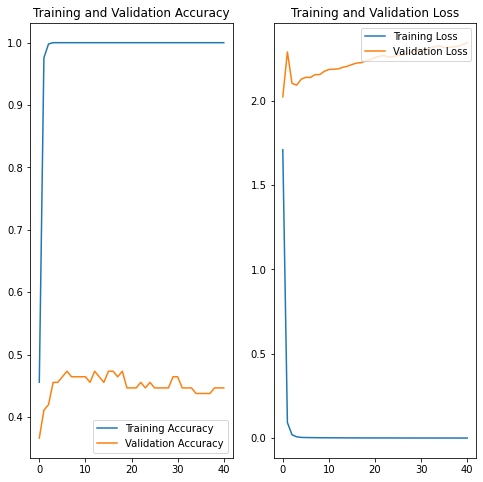

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Y_pred = model4.predict(val_data_gen)
y_pred = np.argmax(Y_pred, axis=1)

In [30]:
def plot_confusion_matrix(y_true,
                          y_pred,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm / cm.astype(np.float).sum(axis=1)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]),   range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.savefig('./saved_figure.png')
    
    image = cv2.imread("./saved_figure.png")
    return image

In [31]:
from sklearn.metrics import classification_report, confusion_matrix
target_names = ['Multicolored - long tail', 'Multicolored - short tail', 'DARK LONG', 'DARK SHORT', 'LIGHT LONG', 'LIGHT SHORT']
report = classification_report(val_data_gen.classes, y_pred, target_names=target_names)
print(report)

                           precision    recall  f1-score   support

 Multicolored - long tail       0.00      0.00      0.00        14
Multicolored - short tail       0.89      0.53      0.67        15
                DARK LONG       0.42      0.68      0.52        22
               DARK SHORT       0.64      0.56      0.60        25
               LIGHT LONG       0.33      0.28      0.30        25
              LIGHT SHORT       0.43      0.60      0.50        25

                 accuracy                           0.47       126
                macro avg       0.45      0.44      0.43       126
             weighted avg       0.46      0.47      0.45       126



Normalized confusion matrix


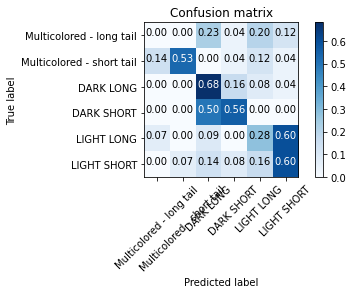

In [32]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import cv2
target_names = ['Multicolored - long tail', 'Multicolored - short tail', 'DARK LONG', 'DARK SHORT', 'LIGHT LONG', 'LIGHT SHORT']
image = plot_confusion_matrix(val_data_gen.classes, y_pred, target_names, normalize=True)

In [36]:
import zipfile
import os

z = zipfile.ZipFile('DogCategory.zip', 'w')        # Создание нового архива
for root, dirs, files in os.walk('./models/DogCategoty_v1.1'): # Список всех файлов и папок в директории folder
    for file in files:
        z.write(os.path.join(root,file))         # Создание относительных путей и запись файлов в архив

z.close()